# Interpretability, Risk Analysis & Validation

In this final notebook, we perform interpretation of model predictions using SHAP, exploration of churn risk scores, and a detailed analysis of prediction errors. Calibration curves are employed to assess model reliability. I'm using the optimized models from Notebook 2 and the Ensemble models from Notebook 3 due to their high holdout set performance, robustness and generalization ability.

In [1]:
!pip install -q catboost shap lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 53.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 33.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [23]:
## Import the necessary libraries required for the task

## Data Manipulation and Visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')
import seaborn as sns

# Turning off warnings
import warnings
warnings.simplefilter('ignore')
## Various libraries for preprocessing, modeling, and evaluation
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.ensemble import VotingClassifier, StackingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, make_scorer, confusion_matrix, ConfusionMatrixDisplay
from sklearn.calibration import calibration_curve

## Explainability
import shap
shap.initjs()
import lime
from lime import lime_tabular

## Utils
import os
import time
from joblib import dump, load

# Setting a maximum width for columns display in pandas dataframe
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)

In [3]:
# Read train-validation and holdout datasets
DATASET_READPATH = "/content/drive/MyDrive/quantspark/datasets"
X_train_val = pd.read_csv(os.path.join(DATASET_READPATH,"X_train_val.csv"))
X_hold_out = pd.read_csv(os.path.join(DATASET_READPATH,"X_hold_out.csv"))
y_train_val = pd.read_csv(os.path.join(DATASET_READPATH,"y_train_val.csv"))
y_hold_out = pd.read_csv(os.path.join(DATASET_READPATH,"y_hold_out.csv"))

In [4]:
# Load Optimized models
MODEL_READPATH = "/content/drive/MyDrive/quantspark/models"
CBClf = load(os.path.join(MODEL_READPATH, "CBClf_opt_model.joblib"))
DTClf = load(os.path.join(MODEL_READPATH, "DTClf_opt_model.joblib"))
GBClf = load(os.path.join(MODEL_READPATH, "GBClf_opt_model.joblib"))
RFClf = load(os.path.join(MODEL_READPATH, "RFClf_opt_model.joblib"))
StackedClf = load(os.path.join(MODEL_READPATH, "StackingClf_model.joblib"))
VotingClf = load(os.path.join(MODEL_READPATH, "VotingClf_model.joblib"))

### Holdout Set Performance - Initial Validation

In [5]:
models = {
    "CBClf": CBClf,
    "DTClf": DTClf,
    "GBClf": GBClf,
    "RFClf": RFClf,
    "StackedClf": StackedClf,
    "VotingClf": VotingClf
}

for name, model in models.items():
    # Predicting on hold-out set
    y_pred = model.predict(X_hold_out)
    y_pred_proba = model.predict_proba(X_hold_out)[:, 1] if hasattr(model, "predict_proba") else None

    # Calculate metrics
    accuracy = accuracy_score(y_hold_out, y_pred)
    f1 = f1_score(y_hold_out, y_pred)
    roc_auc = roc_auc_score(y_hold_out, y_pred_proba) if y_pred_proba is not None else 'N/A'

    # Print the metrics
    print(f"{name}: Accuracy: {accuracy}, F1 Score: {f1}, ROC-AUC: {roc_auc}")


CBClf: Accuracy: 0.9998, F1 Score: 0.9852941176470589, ROC-AUC: 0.9999526679498911
DTClf: Accuracy: 0.9998, F1 Score: 0.9852941176470589, ROC-AUC: 0.9999453427516599
GBClf: Accuracy: 0.99985, F1 Score: 0.988929889298893, ROC-AUC: 0.999983471347581
RFClf: Accuracy: 0.9998, F1 Score: 0.9852941176470589, ROC-AUC: 0.9999894817666425
StackedClf: Accuracy: 0.99985, F1 Score: 0.988929889298893, ROC-AUC: 0.999983471347581
VotingClf: Accuracy: 0.99985, F1 Score: 0.988929889298893, ROC-AUC: 0.999983471347581


I'll proceed with the voting classifier for explainability and risk predictions due to it's high validation scores on holdout sets

### Feature Importance

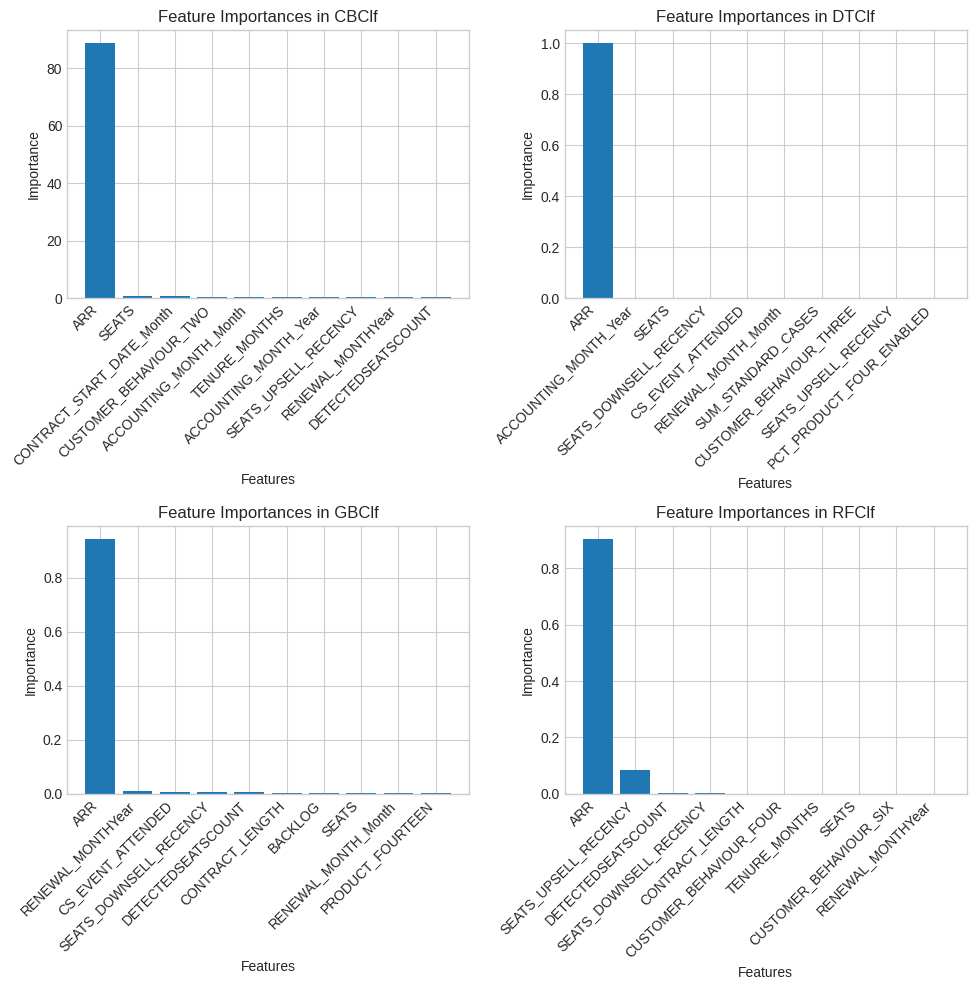

In [6]:
featimp_models = {
    "CBClf": CBClf,
    "DTClf": DTClf,
    "GBClf": GBClf,
    "RFClf": RFClf,
}

# Number of features to display
num_features = 10

# Create subplots
fig, axes = plt.subplots(2,2, figsize=(10,10))
axes = axes.ravel()  # Flatten the 2D array of axes

for i, (model_name, model) in enumerate(featimp_models.items()):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    axes[i].bar(range(num_features), importances[indices[:num_features]])
    axes[i].set_xticks(range(num_features))
    axes[i].set_xticklabels([X_train_val.columns[i] for i in indices[:num_features]], rotation=45, ha='right')
    axes[i].set_title(f'Feature Importances in {model_name}')
    axes[i].set_ylabel('Importance')
    axes[i].set_xlabel('Features')

plt.tight_layout()
plt.show()

In all models, 'ARR' (Annual Recurring Revenue) stands out as a crucial indicator, suggesting it should be a primary focus in understanding and addressing customer churn.

In [7]:
y_pred_proba = VotingClf.predict_proba(X_hold_out)[:, 1]
y_pred = VotingClf.predict(X_hold_out)

y_pred_proba_cbclf = CBClf.predict_proba(X_hold_out)[:, 1]
y_pred_cbclf = CBClf.predict(X_hold_out)

### Customers with high risk of churn

In [9]:
risk_scores = pd.DataFrame({'Actual Value': y_hold_out['CHURN'].tolist(),'Predicted Value':y_pred, 'Churn Risk Score' : y_pred_proba})
risk_scores[risk_scores['Predicted Value'] == 1].head()

,Actual Value,Predicted Value,Churn Risk Score
55,1,1,0.982453
78,1,1,0.982356
320,1,1,0.982451
361,1,1,0.982465
640,1,1,0.982464


- In the above dataframe, we can see the fist 5 customers which the model has predicted to churn along with their churn risk score. The higher the risk score, the higher probability of the customer to churn.
- The holdout set is representative of a test set, however since we don't have a seperate test set, I'm also displaying the ground truth values for reference purposes.

### SHAP Explainer

I've used the SHAP (SHapley Additive exPlanations) technique in order to explain the predictions of the machine learning models. SHAP is a very powerful technique which adopts a game theory approach to ascertain the contributions of different features behind a certain prediction.

SHAP values, which are obtained on feeding the dataset to the SHAP explainers show how each feature affects each final prediction and the significance of each feature compared to others.

In [10]:
# Tree Explainer to explain tree-based model predictions
explainer = shap.TreeExplainer(GBClf)
shap_values = explainer(X_hold_out)

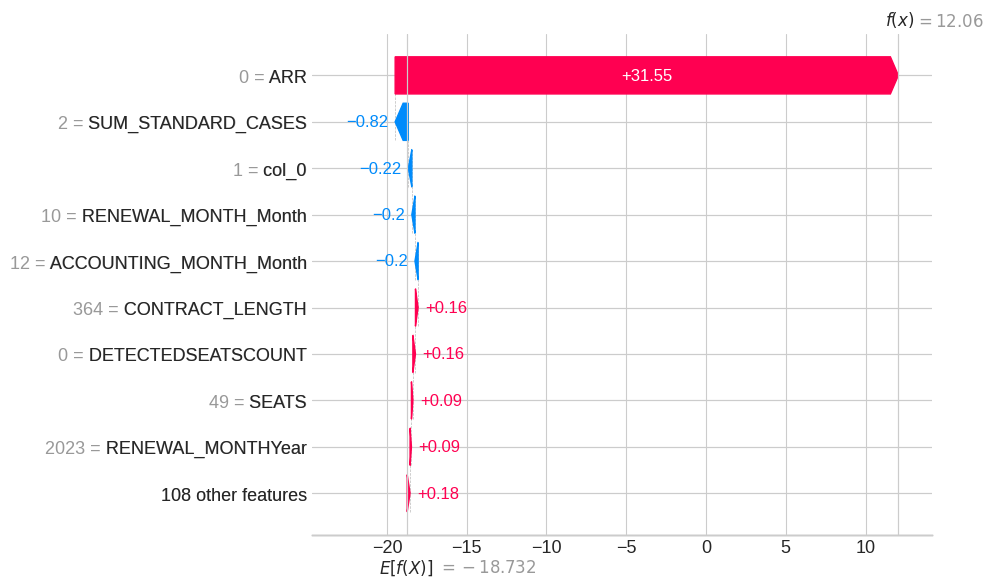

In [11]:
shap.plots.waterfall(shap_values[78])

- The base value (E[f(X)]) is the average model output over the training dataset, and the sum of the SHAP values plus the base value gives us the final prediction (f(X)) for this instance. The way in which this can be understood in layman terms is that the feature values corresponding to the red bars are 'pushing' the predictions towards 1 i.e. churn whereas those corresponding towards blue are 'pushing' the predictions towards 0.
- From the above graph, ARR is the most significant positive contributor to the model's output. An ARR value of 0 is found in customer who have a high probability of churn meaning, customers who are likely to churn do not contribute anything in revenue for the business.
- SUM_STANDARD_CASES and other features like RENEWAL_MONTH_Month and ACCOUNTING_MONTH_Month slightly decrease the churn probability, indicating their negative relationship with churn for this customer.
    

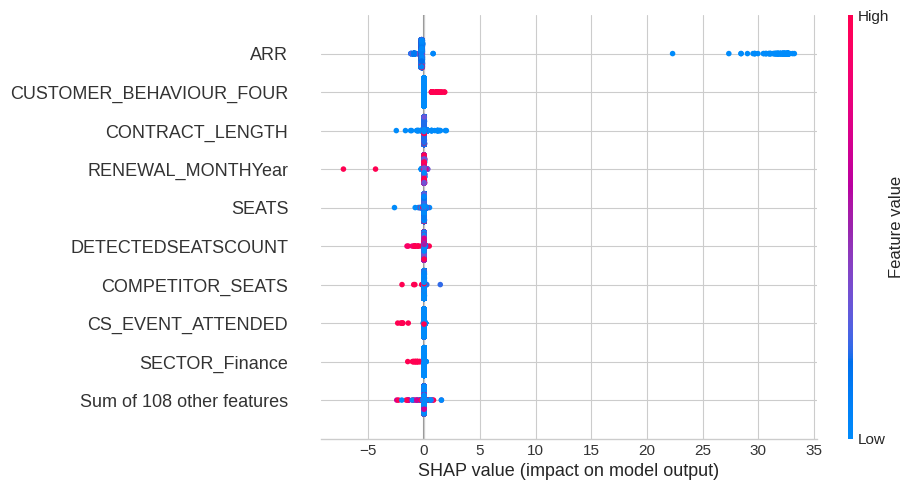

In [12]:
shap.plots.beeswarm(shap_values)

The above graph clearly indicates that along with ARR being a very high impact features, low values of ARR correspond to a higher likelihood of customer churn.

In [13]:
risk_scores[(risk_scores['Churn Risk Score'] > 0.001) & (risk_scores['Churn Risk Score'] < 0.9)]

,Actual Value,Predicted Value,Churn Risk Score
6278,0,0,0.031411


The customer is index 6278 is the only customer who has a higher churn risk score than 0.001. The risk is still relatively less but the cause behind a slightly elevated risk warrants further investigation.

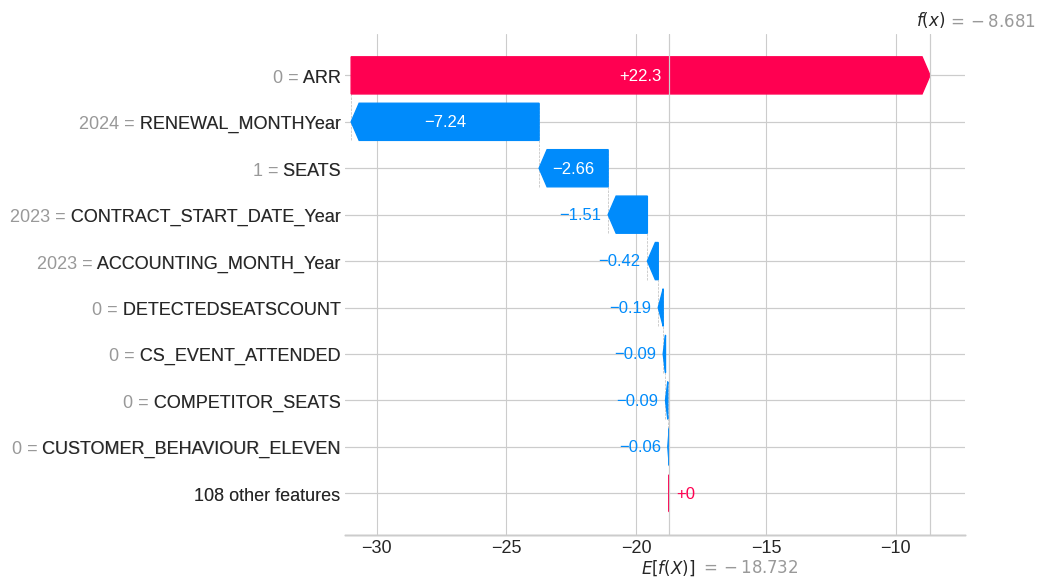

In [14]:
shap.plots.waterfall(shap_values[6278])

The customer in index 6278 might be a potential case of churn as the ARR is 0, which has consistently been seen in customers who have churned prior.
The model has currently predicted the customer to not churn as the year the contract renewal in 2024, however, there is a potential risk of this customer to churn in the future. Hence, effective action needs to be taken by the business to monitor this customer and make efforts to retain them.

### LIME Explainer

I've also used the LIME (Local Interpretable Model-Agnostic Explanations) library which uses proxy more interpretable models to explain predictions of more complex models. In this case however, SHAP yields better explanations than LIME.

In [ ]:
# Initialize the LIME explainer
explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train_val),
    feature_names=X_train_val.columns,
    class_names=['Not Churn', 'Churn'],
    mode='classification'
)

In [ ]:
# Explain a single prediction from the hold-out set
i = 78  # index of the instance to explain
exp = explainer.explain_instance(X_hold_out.iloc[i], model.predict_proba, num_features=10)

# Show the explanation
exp.show_in_notebook(show_table=True)

### Model Error Analysis (Potential Churn)

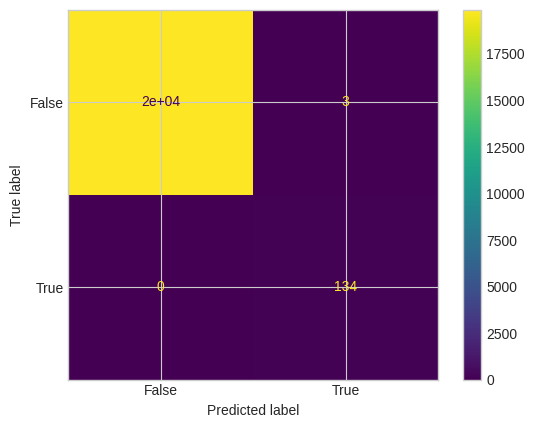

In [24]:
## Confusion Matrix
c_mat = confusion_matrix(y_hold_out, y_pred)

cm_display = ConfusionMatrixDisplay(confusion_matrix = c_mat, display_labels = [False, True])

cm_display.plot()
plt.show()

In [25]:
y_pred.shape

(20000,)

- We can see that out of 20000 predictions, the model has incorrectly predicted only 3 values. All 3 of them are False Positives and hence are not as critical for this business as a False Negative.
- Falsely predicting a churning customer as non-churn (False Negative) would be much more detrimental for the business than vice-versa.

However, let's investigate the reasons of the errors.

In [83]:
risk_scores[risk_scores['Actual Value'] != risk_scores['Predicted Value']]

,Actual Value,Predicted Value,Churn Risk Score
862,0,1,0.982198
6997,0,1,0.982411
13804,0,1,0.982252


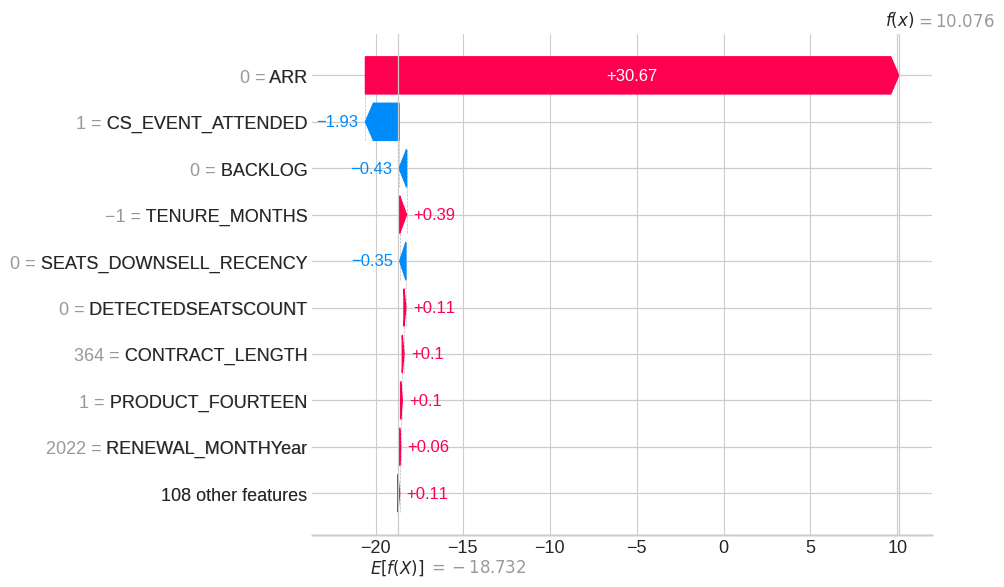

In [119]:
shap.plots.waterfall(shap_values[862])

- We can observe from the explanations that the customers have been incorrectly classified as churn customers due to their ARR being 0 which is a pattern noticed in churn customers.
- Although the ground truth reveals these customers have not churned, the observations definitely reveal that these customer are cases of potential churn and should be monitored in a similar manner as high risk customers.

Hence, in this way, error analysis actually worked to our advantage in identifying potential churn.

### Calibration Curve

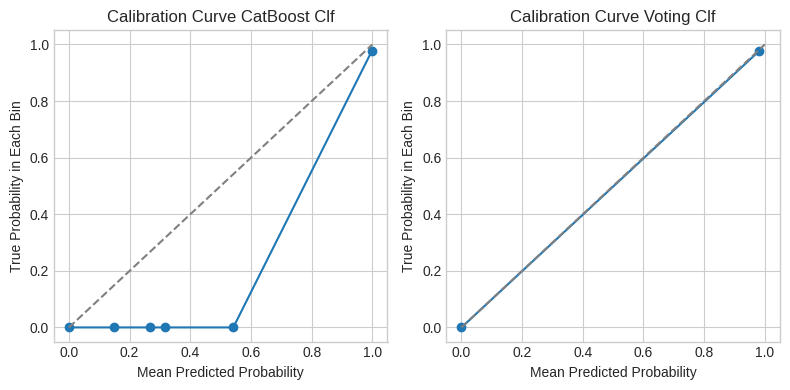

In [132]:
true_probas_cbclf, predicted_probas_cbclf = calibration_curve(y_hold_out, y_pred_proba_cbclf, n_bins=10)
true_probas, predicted_probas = calibration_curve(y_hold_out, y_pred_proba, n_bins=10)

# Create a figure with 2 subplots side by side
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

# Calibration curve for the first model
ax[0].plot(predicted_probas_cbclf, true_probas_cbclf, marker='o')
ax[0].plot([0, 1], [0, 1], linestyle='--', color='grey')
ax[0].set_xlabel('Mean Predicted Probability')
ax[0].set_ylabel('True Probability in Each Bin')
ax[0].set_title('Calibration Curve CatBoost Clf')

# Calibration curve for the second model
ax[1].plot(predicted_probas, true_probas, marker='o')
ax[1].plot([0, 1], [0, 1], linestyle='--', color='grey')
ax[1].set_xlabel('Mean Predicted Probability')
ax[1].set_ylabel('True Probability in Each Bin')
ax[1].set_title('Calibration Curve Voting Clf')

plt.tight_layout()
plt.show()

- For predicted probabilities between 0 and 0.6, the CatBoost classifier is underconfident. The actual probabilities of the positive class are higher than the model's predictions.
- The Voting classifier's predicted probabilities are very well-calibrated across all bins. The curve closely follows the diagonal line, which indicates that the predicted probabilities match the true probabilities well.
- A well-calibrated model will have a calibration curve that closely follows the diagonal dashed line. Deviations from this line indicate that the model's probabilities are not perfectly aligned with the true frequencies of the outcomes.

In this case, the Voting classifier seems to be better calibrated than the CatBoost classifier, especially for lower predicted probabilities. Good calibration is particularly important in churn prediction where trust in probability scores is crucial for making decisions, such as when to intervene with customer retention strategies.

---
# Conclusion

From the beginning of this project, I endeavoured to predict customer churn based on the provided renewals dataset. Through rigorous data exploration, data preprocessing, feature engineering, modelling, optimization, ensembling and model explainability, I tackled this challenge systematically.

In order to address the problem areas of the client:-
1. A robust model to predict customer churn was built
2. A customer churn model was built to predict churn to provide their team to action preventative measures. Additionally, potential cases of future churn were also identified for the team to be aware of and take appropriate measures.
3. A risk score was provided representing the churn propensity. Extensive explainability measures were employed to enable transparency and foster trust and reliance for the model predictions and enable customer success by effective conversations.
4. Model was rigorously validated and analyzed using techniques like stratified kfold cross validation, holdout set, monitoring multiple relevant validation metrics, explainability, calibration etc. This helps bolster trust and confidence in the client regarding the model performance and facilitates effective data-driven decision making
In order to Subsequent hyperparameter optimization fine-tuned the models to improve the predictive power even further.

In conclusion, I tackled the task of predicting customer churn and through meticulous and iterative efforts, achieved an insightful model that can predict churn with a notable degree of accuracy. This underscores the significance of methodical data analysis and advanced modeling in addressing real-world challenges.

# Future Work
1. Advanced Feature Engineering: Explore more sophisticated feature interactions and time-series analyses to capture trends and patterns over time that may influence churn.
2. Improved Neural Networks : Experiment with different neural networks and improve the existing dense network using different architectures and introducing more regularization .
3. Unsupervised Learning for Customer Segmentation: Implement clustering techniques to identify distinct customer segments, which could lead to more tailored predictive models for each group.

----